# Layer 4 project. Ephys properties strip plot

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import scipy

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7
    
sns_styleset()

In [18]:
data = pd.read_csv('data/patch-morph-ephys-features.csv', index_col=0)
data.loc[data['Cell type']=='BC', 'Cell type'] = 'LBC'
data.loc[data['Cell type']=='SC', 'Cell type'] = 'SBC'
data.loc[data['Cell type']=='HEC', 'Cell type'] = 'HBC'

y = data['Cell type'].values
data['AI'] = np.array(data['AI'])/100

X = data.values[:,:-1].astype(float)
AIind = np.where(np.array(data.columns[:-1]) == 'AI')[0][0]
X[:,AIind] = np.log2(X[:,AIind])

LATind = np.where(np.array(data.columns[:-1]) == 'Latency (ms)')[0][0]
X[:,LATind] = np.log2(X[:,LATind])

<IPython.core.display.Javascript object>


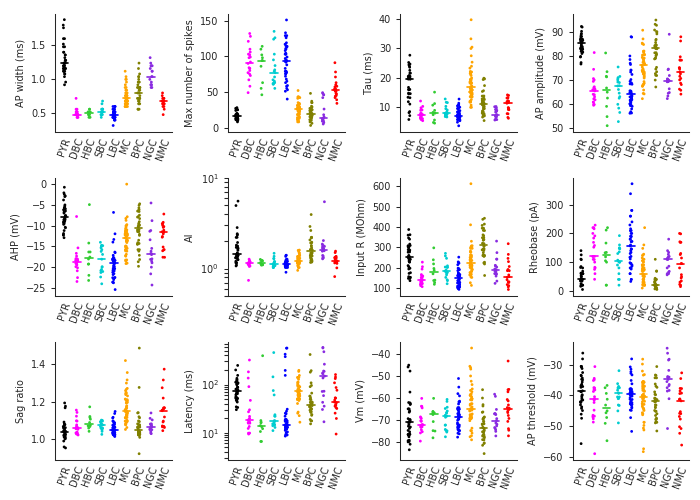

In [19]:
sns_styleset()

fig, axes = plt.subplots(3, 4, figsize = (7, 5))

order = ['PYR', 'DBC', 'HBC', 'SBC', 'LBC', 'MC', 'BPC', 'NGC', 'NMC']

colors = {'BPC':'#808000', 'MC':'#fea400', 'DBC':'#fe00fe', 'HBC':'#32cc32',
          'SBC':'#00cdd0', 'PYR':'#000000', 'LBC':'#0000fe', 'NGC':'#892be1',
          'NMC': '#ff0000'}

KW = []
for f in range(X.shape[1]):
    KW.append(scipy.stats.kruskal(X[y=='PYR',f], X[y=='DBC',f], X[y=='HBC',f], X[y=='SBC',f],
                    X[y=='LBC',f], X[y=='MC',f], X[y=='BPC',f], X[y=='NGC',f]).statistic)
featureorder = np.argsort(KW)[::-1][:-1]

for feature, axis in zip(data.columns[:-1][featureorder], axes.reshape(-1)):
    sns.stripplot(x = 'Cell type', y = feature, data = data,#.loc[data['Cell type']!='NMC',:], 
                  palette = colors, jitter = True, ax = axis, s = 2, order = order, zorder=0)
    
#     axis.scatter(x = 9 + (np.random.rand(np.sum(data['Cell type']=='NMC'))-.5)/5,
#                 y = data.loc[data['Cell type']=='NMC', feature],
#                 color = 'red', s = 1, zorder=0)
    
    axis.set_xlabel('')
    axis.tick_params(axis='x', which='both', length=0, rotation = 70)
    
    for i, celltype in enumerate(order):
        m = np.median(data[feature][y==celltype])
        axis.plot([i-.3,i+.3], [m,m], 'k', zorder=1, color=colors[celltype])

AIax  = axes.reshape(-1)[featureorder==AIind][0]
AIax.set_yscale('log')
AIax.set_ylim([.5,10])
LATax  = axes.reshape(-1)[featureorder==LATind][0]
LATax.set_yscale('log')

sns.despine()
plt.tight_layout()

plt.savefig('../figures/ephys-features.png', dpi=200)
plt.savefig('../figures/ephys-features.pdf')

## t-SNE

In [20]:
from sklearn.manifold import TSNE
from sklearn.covariance import MinCovDet

In [21]:
def coverageEllipse(data, coverage=.8, edgecolor=None, facecolor='none', linewidth=1, 
                    zorder=None, robust=False, label=None, fontsize=8, bbox=None, 
                    textcolor='w', labeloffset=(0,0)):
    multiplier = scipy.stats.chi2.ppf(coverage, 2)

    if robust:
        from sklearn.covariance import MinCovDet
        mcd = MinCovDet(random_state=42).fit(data)
        mu = mcd.location_
        Sigma = mcd.covariance_
    else:
        mu = data.mean(axis=0)
        Sigma = np.cov(data, rowvar=False)

    val, vec = np.linalg.eigh(Sigma)
    width, height = 2 * np.sqrt(val[:, None] * multiplier)
    theta = np.degrees(np.arctan2(*vec[::-1, 0]))
    ellip = matplotlib.patches.Ellipse(xy=mu, width=width, height=height, angle=theta, 
        edgecolor=edgecolor, linewidth=linewidth, facecolor=facecolor, zorder=zorder)
    plt.gca().add_artist(ellip)
    
    if label:
        plt.text(mu[0]+labeloffset[0], mu[1]+labeloffset[1], label, 
                 color=textcolor, fontsize=fontsize, ha='center', va='center', bbox=bbox)

In [26]:
ephys = pd.read_csv('data/patch-morph-ephys-features.csv', index_col='name sample')
ephys.loc[ephys['Cell type']=='BC', 'Cell type'] = 'LBC'
ephys.loc[ephys['Cell type']=='SC', 'Cell type'] = 'SBC'
ephys.loc[ephys['Cell type']=='HEC', 'Cell type'] = 'HBC'

y_ephys = ephys['Cell type'].values.astype(str)
cells_ephys = np.array([c for c in ephys.index])
ind = np.array(ephys.columns)[:-1]
X = ephys.iloc[:,:-1].values.astype('float')

# log transform AI
X[:,np.isin(ind, ['AI'] )] = np.log(X[:,np.isin(ind, ['AI'] )]/100)

# drop ADP and latency
X = X[:,~np.isin(ind, ['ADP (mV)','Latency (ms)'] )]

XX = X.copy()
XX = XX - XX.mean(axis=0)
XX = XX / XX.std(axis=0)
U,s,V = np.linalg.svd(XX, full_matrices=False)
Z = U @ np.diag(s)

ZZ_ephys = TSNE(perplexity=15, method='exact', random_state=42, early_exaggeration=4).fit_transform(Z)

<IPython.core.display.Javascript object>


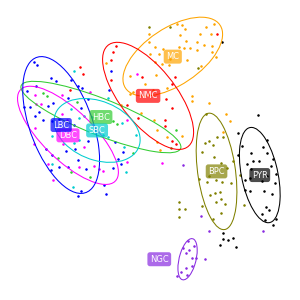

In [27]:
plt.figure(figsize=(3,3))

colors = {'BPC':'#808000', 'MC':'#fea400', 'DBC':'#fe00fe', 'HBC':'#32cc32',
          'SBC':'#00cdd0', 'PYR':'#000000', 'LBC':'#0000fe', 'NGC':'#892be1',
          'NMC': '#ff0000'}

labels, yy = np.unique(y_ephys, return_inverse=True)

for cl in range(labels.size):
    plt.scatter(ZZ_ephys[yy==cl,0], ZZ_ephys[yy==cl,1], color=colors[labels[cl]], s=1)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

offsets = {'NGC': (-10,0)}
for cl,l in enumerate(labels):
    props = dict(boxstyle='round', facecolor=colors[l], edgecolor='none', alpha=0.7)
    coverageEllipse(ZZ_ephys[yy==cl,:], edgecolor=colors[l], robust=True, 
                    label=labels[cl], bbox=props, fontsize=6, linewidth=0.75,
                    labeloffset=(0,0) if l not in offsets else offsets[l])

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('../figures/ephys-tsne-with-nmc.png', dpi=200)
plt.savefig('../figures/ephys-tsne-with-nmc.pdf')

# PCA

PCA on NMC, BC, HEC, MC, DBC and SC cells only

In [29]:
# Biplot function
def bibiplot_ephys_only(Y, v, 
             YdimsNames=np.array([]), YdimsToShow=np.array([]),
             titles=[], xylim = 3,
             cellTypes=np.array([]), cellTypeColors={}, cellTypeLabels={},
             figsize=(9,4), scaleFactor = 2, corr = np.array([]), second_labels = np.array([]),
             axes=None, pcaComponents = None):
    
    # Project and standardize
    if not pcaComponents:
        Zy = Y @ v[:,:2]
    else:
        Zy = Y @ v[:, pcaComponents]
    Zy = Zy / np.std(Zy, axis=0)
    plt.figure(figsize=figsize)
    if titles:
        plt.title(titles[1])
    if corr.size > 0:
        plt.annotate(r'$\rho_1$ = {}'.format(corr[0]), xy=(xylim-1, -xylim + 1.2), xytext=(xylim-1, -xylim + 1.2))
        plt.annotate(r'$\rho_2$ = {}'.format(corr[1]), xy=(xylim-1, -xylim + 0.7), xytext=(xylim-1, -xylim + 0.7))
        
    if cellTypes.size == 0:
        plt.scatter(Zy[:,0], Zy[:,1])
    else:
        for u in np.unique(cellTypes):
            # if, else statement added by Yves Bernaerts for the specific layer 4 project
            if not second_labels.size:
                plt.scatter(Zy[cellTypes==u,0], Zy[cellTypes==u,1], color=cellTypeColors[u], label = cellTypeLabels[u])
            else:
                V1_ind = (second_labels == 1) | (second_labels == 3) # V1       
                S1_ind = (second_labels == 2) | (second_labels == 4) # S1
                Zy_V1 = Zy[V1_ind, :]
                Zy_S1 = Zy[S1_ind, :]
                cellTypes_V1 = cellTypes[V1_ind]
                cellTypes_S1 = cellTypes[S1_ind]
                plt.scatter(Zy_V1[cellTypes_V1==u, 0], Zy_V1[cellTypes_V1==u, 1], \
                           color = cellTypeColors[u], label = 'V1 ' + cellTypeLabels[u], marker = 'o')
                plt.scatter(Zy_S1[cellTypes_S1==u, 0], Zy_S1[cellTypes_S1==u, 1], \
                           color = cellTypeColors[u], label = 'S1 ' + cellTypeLabels[u], marker = 'd', s = 60)
    if cellTypeLabels:
        plt.legend(bbox_to_anchor=(0.9, 0.9))            
    plt.xlim([-xylim,xylim])
    plt.ylim([-xylim,xylim])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()

    if YdimsToShow.size > 0:
        L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
        for i in YdimsToShow:
            plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=1, color=[.4, .4, .4])
            plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, YdimsNames[i], 
                     ha='center', va='center', color=[.4, .4, .4], fontsize=10)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=1)
        plt.gca().add_patch(circ)


<IPython.core.display.Javascript object>


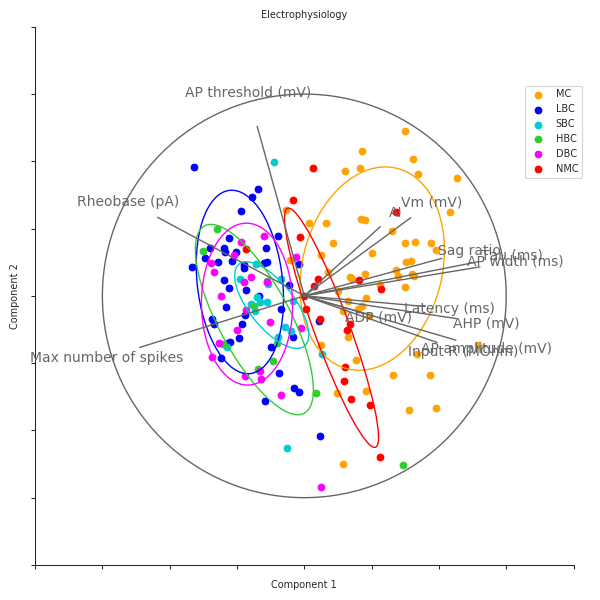

In [30]:
ephys = pd.read_csv('data/patch-morph-ephys-features.csv', index_col='name sample')
ephys.loc[ephys['Cell type']=='BC', 'Cell type'] = 'LBC'
ephys.loc[ephys['Cell type']=='SC', 'Cell type'] = 'SBC'
ephys.loc[ephys['Cell type']=='HEC', 'Cell type'] = 'HBC'

ind = (ephys['Cell type'] == 'NMC') | (ephys['Cell type'] == 'MC') | \
       (ephys['Cell type'] == 'LBC') | (ephys['Cell type'] == 'DBC') | \
       (ephys['Cell type'] == 'HBC') | (ephys['Cell type'] == 'SBC')
ephys = ephys.loc[ind, :]
y_ephys = ephys['Cell type'].values.astype(str)

cellTypes = np.zeros(len(list(ephys.index)))
for i, cell in enumerate(y_ephys):
    if cell == 'MC':
        cellTypes[i] = 1
    elif cell == 'LBC':
        cellTypes[i] = 2
    elif cell == 'SBC':
        cellTypes[i] = 3
    elif cell == 'HBC':
        cellTypes[i] = 4
    elif cell == 'DBC':
        cellTypes[i] = 5
    elif cell == 'NMC':
        cellTypes[i] = 6

colors = {'MC':'#fea400', 'LBC':'#0000fe', 'SBC':'#00cdd0', 'HBC':'#32cc32', 'DBC':'#fe00fe', 'NMC': '#ff0000'}
colors_list = ['#fea400', '#0000fe', '#00cdd0', '#32cc32', '#fe00fe', '#ff0000']
cellTypeColors = dict(zip(range(1,7), colors_list))
cellTypeLabels = dict(zip(range(1,7), ['MC', 'LBC', 'SBC', 'HBC', 'DBC', 'NMC']))
        
cells_ephys = np.array([c for c in ephys.index])
ind = np.array(ephys.columns)[:-1]
X = ephys.iloc[:,:-1].values.astype('float')

# log transform AI and latency
X[:,np.isin(ind, ['AI'] )] = np.log(X[:,np.isin(ind, ['AI'] )]/100)
X[:,np.isin(ind, ['Latency (ms)'] )] = np.log2(X[:,np.isin(ind, ['Latency (ms)'] )])


XX = X.copy()
XX = XX - XX.mean(axis=0)
XX = XX / XX.std(axis=0)

uy,sy,vy = np.linalg.svd(XX, full_matrices=False)
vy = vy.T
uy = uy * np.sign(np.sum(vy, axis=0))
vy = vy * np.sign(np.sum(vy, axis=0))

bibiplot_ephys_only(XX, vy, titles=['RNA expression', 'Electrophysiology'], 
         cellTypes=cellTypes, cellTypeColors=cellTypeColors,
         YdimsNames=ephys.columns[:-1], YdimsToShow=np.arange(XX.shape[1]),
         cellTypeLabels = cellTypeLabels,
         figsize = (6, 6), xylim = 4, scaleFactor = 3)
Zy = XX @ vy[:, :2]
Zy = Zy / np.std(Zy, axis=0)
for item in ['MC', 'LBC', 'SBC', 'HBC', 'DBC', 'NMC']:
        coverageEllipse(Zy[ephys['Cell type']==item, 0:2], edgecolor=colors[item], robust = True)
sns.despine()